In [1]:
!pip install torch===1.0.0 torchvision===0.2.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.8/591.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cpu
    Uninstalling torch-1.13.0+cpu:
      Successfully uninstalled torch-1.13.0+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cpu
    Uninstalling torchvision-0.14.0+cpu:
      Successfully uninstalled torchvision-0.14.0+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.0.0 which is incompatible.
torchmetrics 0.11.4 requires torch>=1.8.1, but you have torch 1.0.0 which is incompatible.
torchaudio 0.13.0+cpu requires torch==1.13.0, but you have torch 

In [2]:
!pip install scipy==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.16.4 requires scipy>=1.4.0, but you have scipy 1.1.0 which is incompatible.
tsfresh 0.20.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
tpot 0.11.7 requires scipy>=1.3.1, but you have scipy 1.1.0 which is incompatible.
stumpy 1.11.1 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
statsmodels 0.13.5 requires scipy<1.8,>=1.3; python_version == "3.7", but you have scipy 1.1.0 which is incompatible.
statsmodels 0.13.5 requires scipy>=1.3; (python_version > "3.9" or platform_system != "Windows" or platform_machine != "x86") and python_ve

In [3]:
!pip3 install pyro-ppl==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyro-ppl: filename=pyro_ppl-0.2.1-py3-none-any.whl size=159538 sha256=28364431c0ef96414387bc0f073310d1e0622b3bda12484f10584c62d5ed1d0a
  Stored in directory: /root/.cache/pip/wheels/d0/90/63/f283d7baeda46dd99208d84676b5135d44595e508c7ff52d5e
Successfully built pyro-ppl


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [5]:
%matplotlib inline

In [6]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

Processing...
Done!


In [7]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [8]:
net = NN(28*28, 1024, 10)
log_softmax = nn.LogSoftmax(dim=1)

In [9]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [10]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [11]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [12]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  2060.1076371469658
Epoch  1  Loss  360.58959998466173
Epoch  2  Loss  156.18409217917124
Epoch  3  Loss  109.65360361215274
Epoch  4  Loss  96.39406453580857


In [13]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean.numpy(), axis=1)
    return torch.argmax(mean, dim=1)


print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [14]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [16]:
num_samples = 10
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [17]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images if predicted_for_images!=0 else 0)
        
    return len(labels), correct_predictions, predicted_for_images 

In [18]:
def my_test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0
    all_predicted = []
    for i in range(len(labels)):
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
        
            if(highlight):
            
                highted_something = True
                
    
        predicted = np.argmax(all_digits_prob)
        all_predicted.append(predicted)
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                correct_predictions +=1.0
    
    all_predicted = torch.Tensor(all_predicted)
    return all_predicted, len(labels), correct_predictions, predicted_for_images 

In [19]:
def my_test_single(image):
    labels = torch.Tensor(np.array([2]))
    images = image.unsqueeze(dim=0)
    y = give_uncertainities(images)
    predicted_for_images = 0
    all_predicted = []
    for i in range(len(labels)):
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
        
            if(highlight):
            
                highted_something = True
                
    
        predicted = np.argmax(all_digits_prob)
        all_predicted.append(predicted)
        if(highted_something):
            predicted_for_images+=1
    
    all_predicted = torch.Tensor(all_predicted)
    return all_predicted, len(labels), predicted_for_images 

In [20]:
print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))
# this cell takes 9 minutes to run

Prediction when network can refuse
Total images:  10000
Skipped:  987
Accuracy when made predictions: 92 %


In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  4


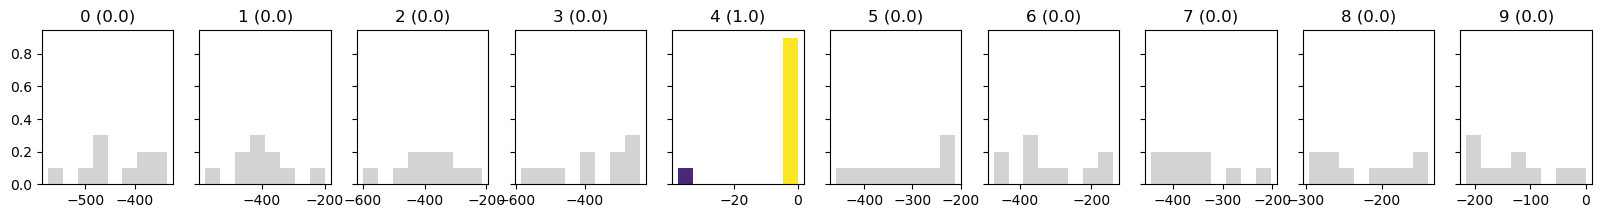

Correct


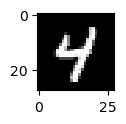

Real:  5


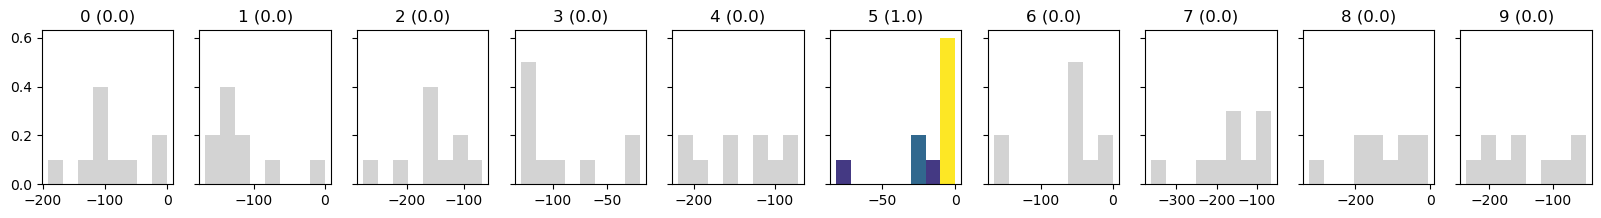

Correct


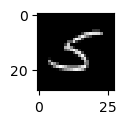

Real:  1


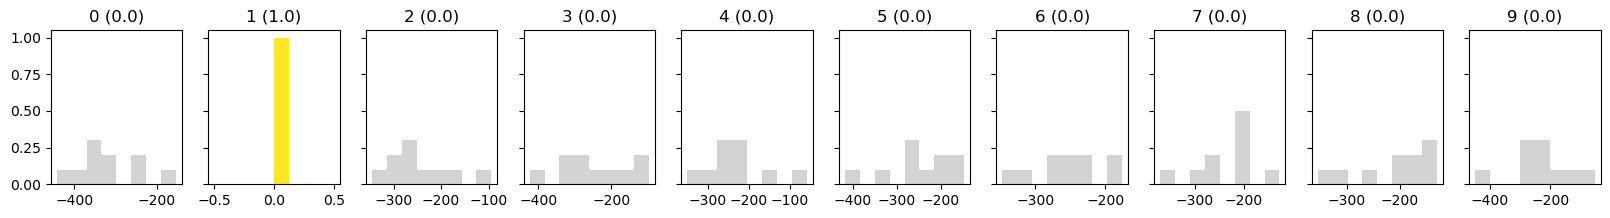

Correct


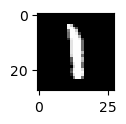

Real:  7


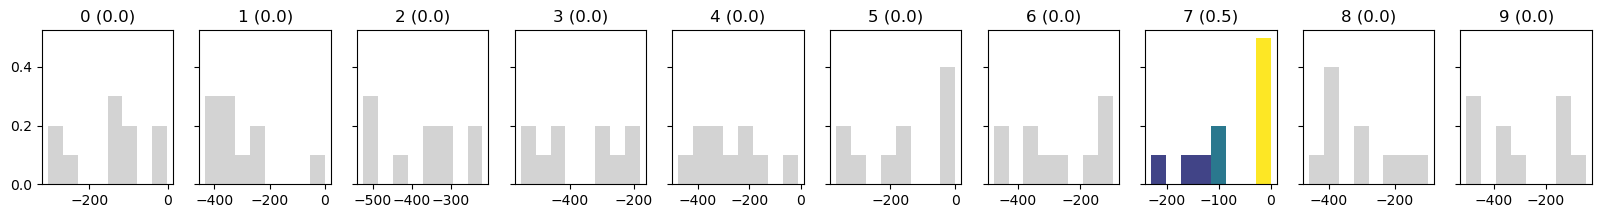

Correct


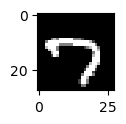

Real:  3


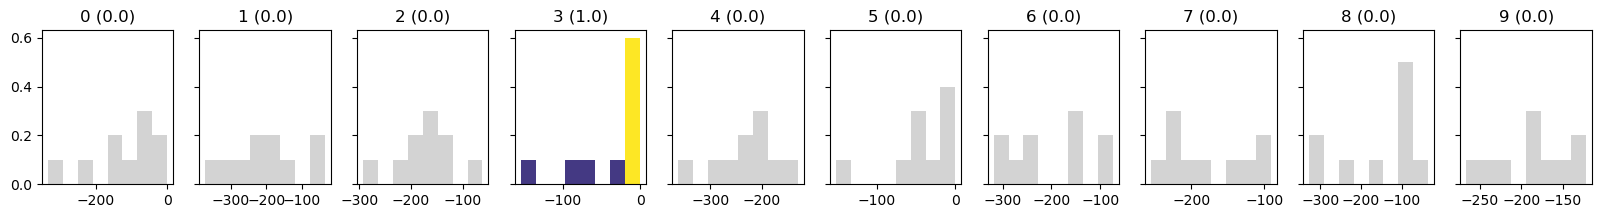

Correct


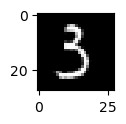

Real:  4


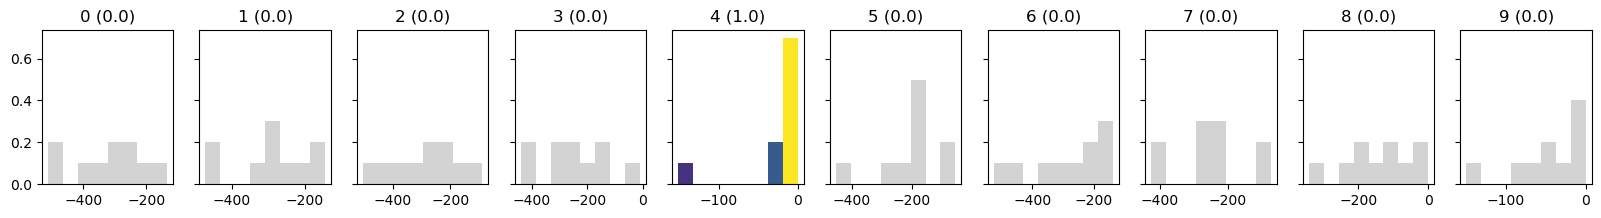

Correct


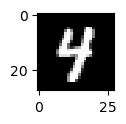

Real:  6


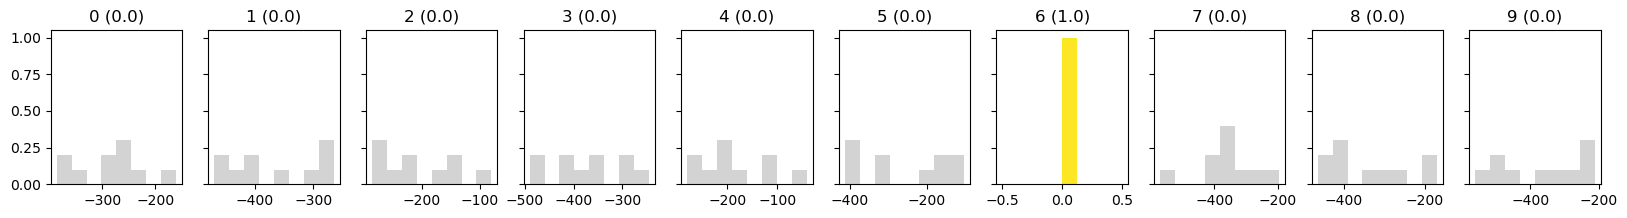

Correct


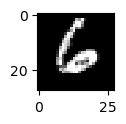

Real:  7


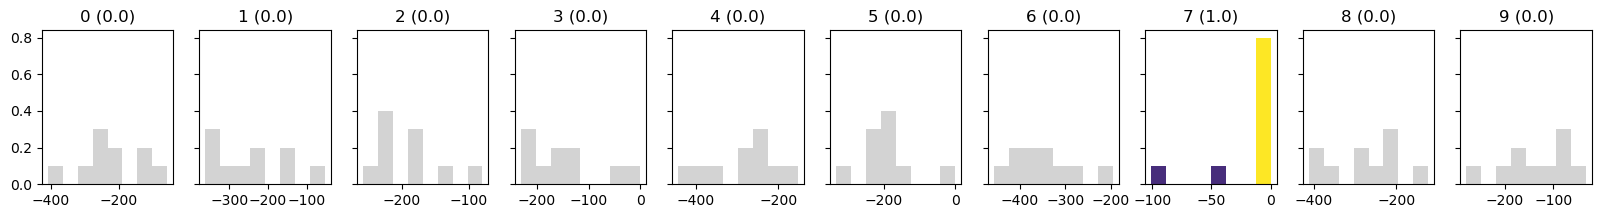

Correct


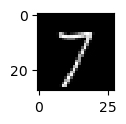

Real:  7


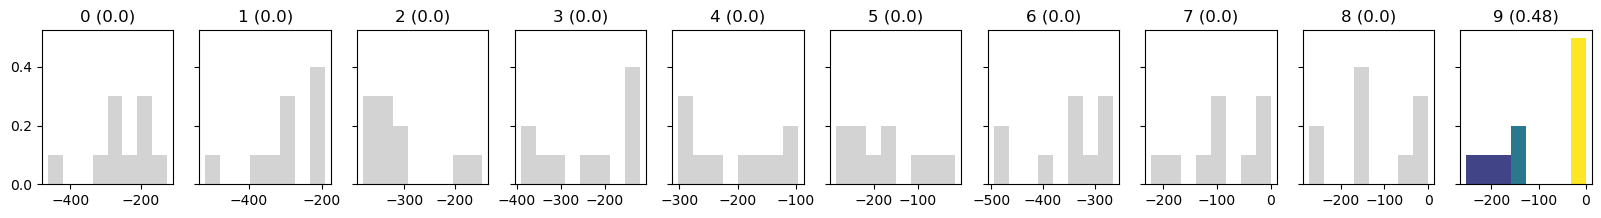

Incorrect :()


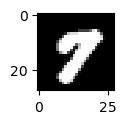

Real:  6


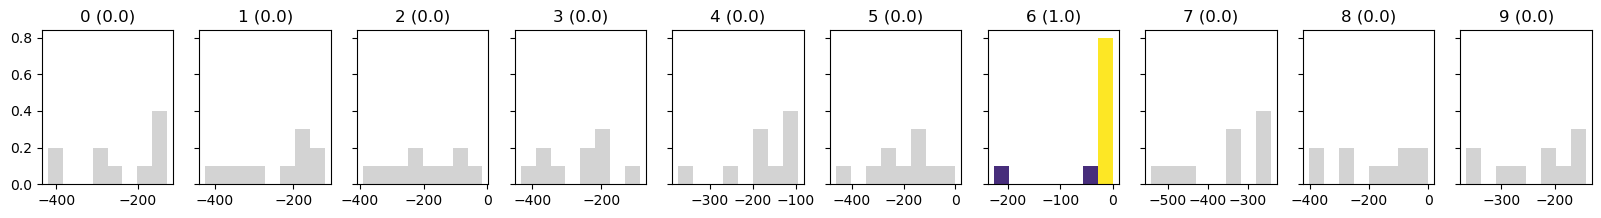

Correct


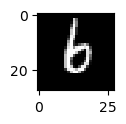

Summary
Total images:  10
Predicted for:  10
Accuracy when predicted:  0.9


(10, 9.0, 10)

In [22]:
test_batch(images[:10], labels[:10])


In [23]:
images_random = torch.rand(10,28,28)
labels_random = torch.randint(0,10, (10,))

Real:  1


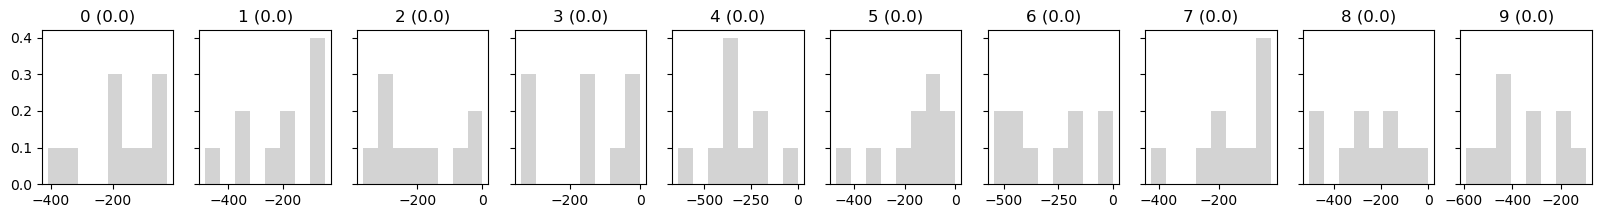

Undecided.


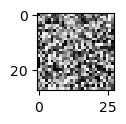

Real:  2


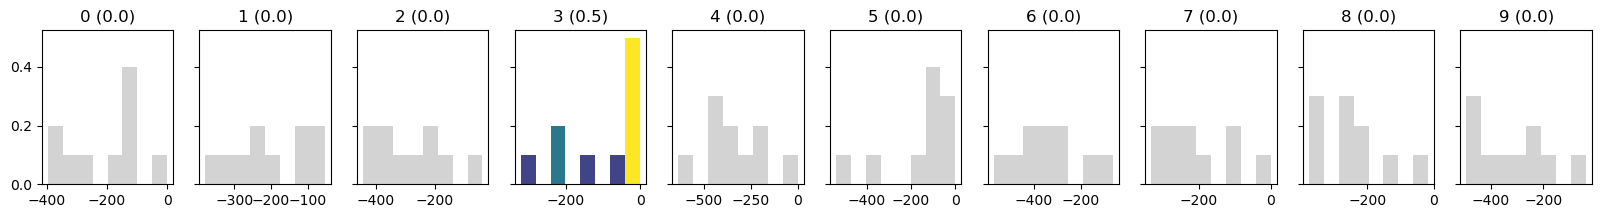

Incorrect :()


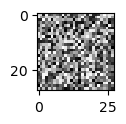

Real:  3


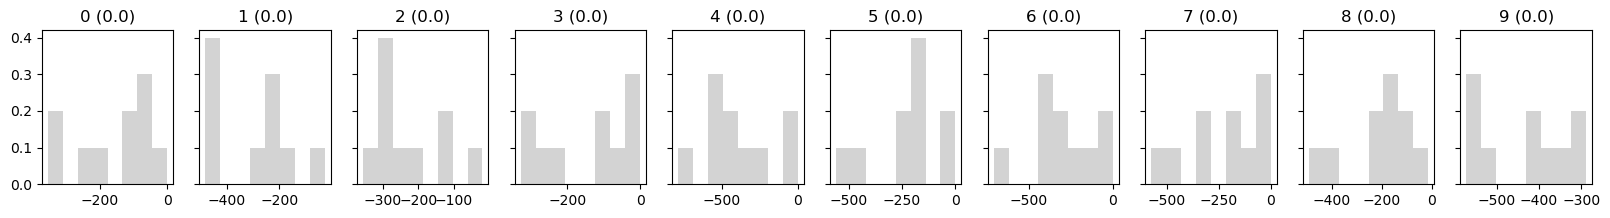

Undecided.


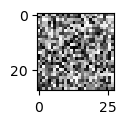

Real:  8


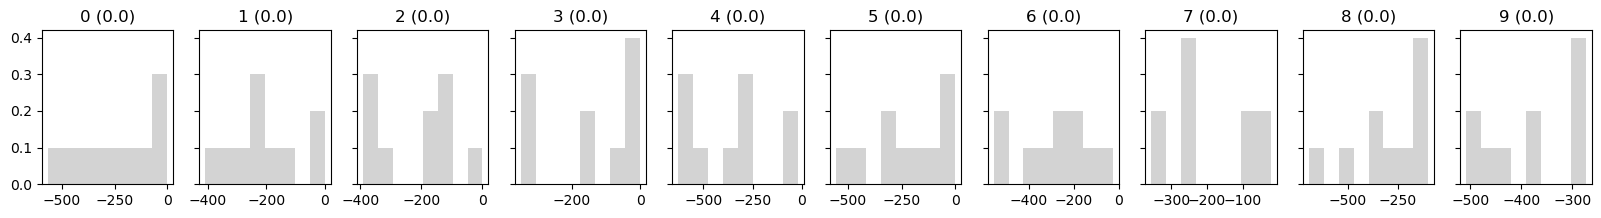

Undecided.


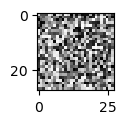

Real:  9


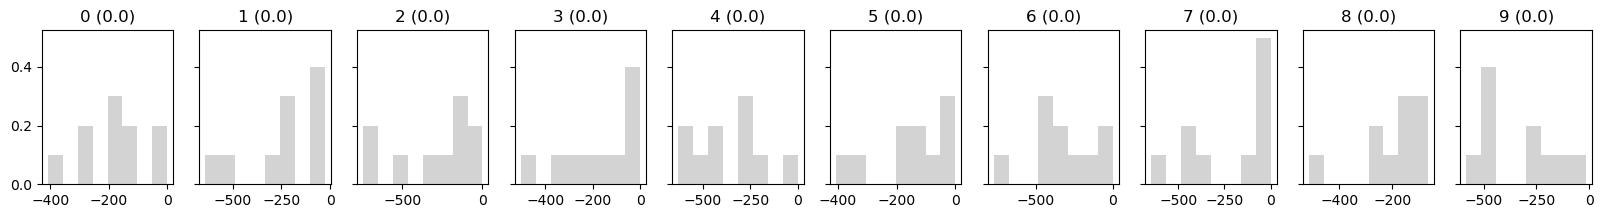

Undecided.


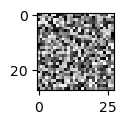

Real:  4


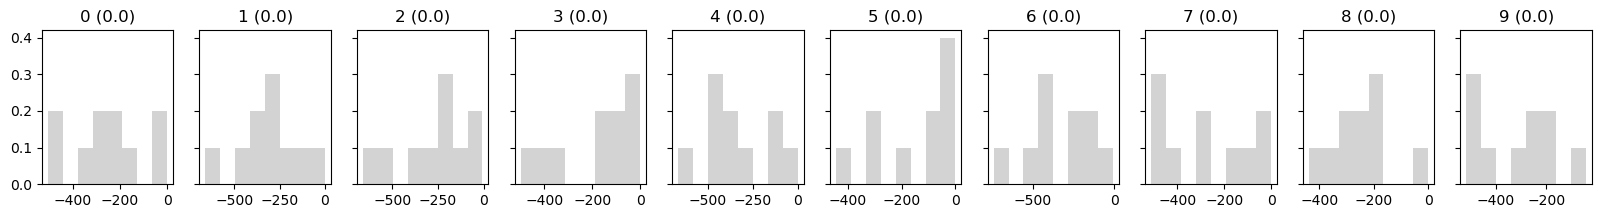

Undecided.


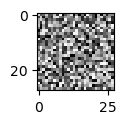

Real:  1


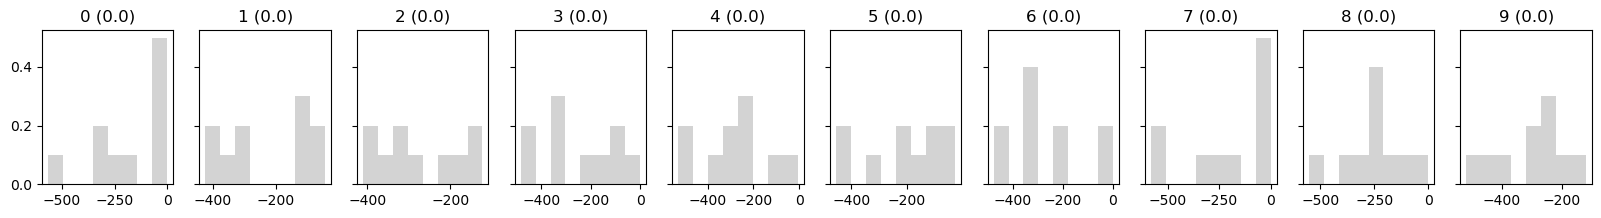

Undecided.


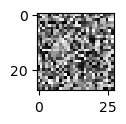

Real:  4


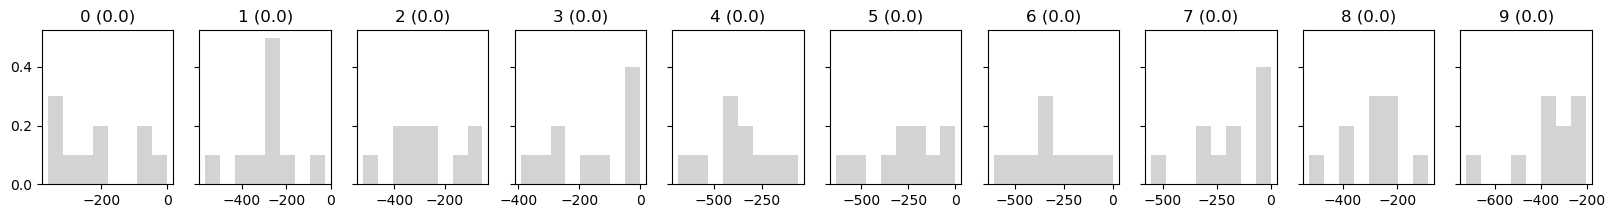

Undecided.


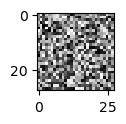

Real:  9


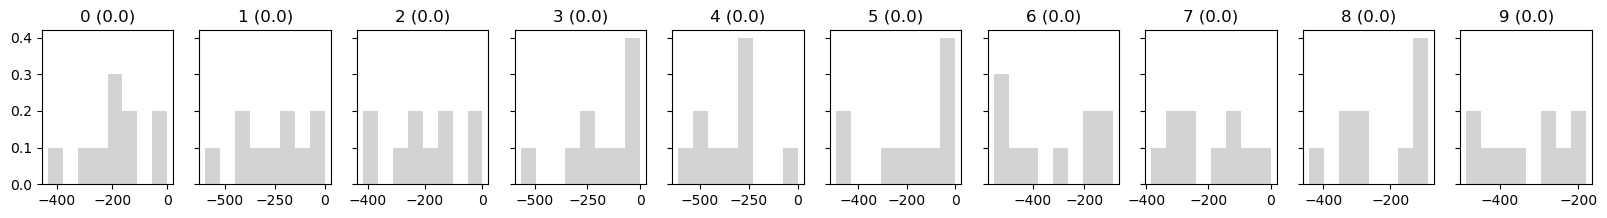

Undecided.


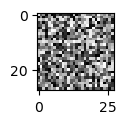

Real:  9


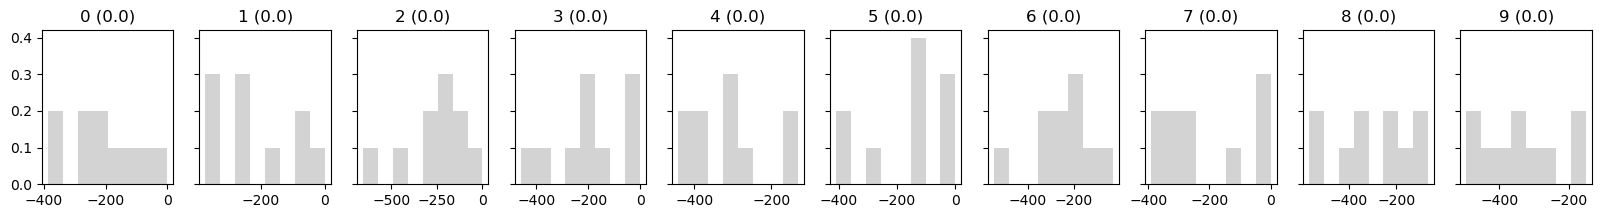

Undecided.


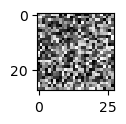

Summary
Total images:  10
Predicted for:  1
Accuracy when predicted:  0.0


(10, 0, 1)

In [24]:
test_batch(images_random, labels_random)
